<a href="https://colab.research.google.com/github/lovepreetmultani/python/blob/main/HeartFailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1006]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime as dt

In [1007]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [1008]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1009]:
heart=pd.read_csv("drive/My Drive/Datasets/Final_heart.csv")

In [1010]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40.0,M,ATA,140.0,289,0,Normal,172,N,0.0,Up,0
1,49.0,F,NAP,160.0,180,0,Normal,156,N,1.0,Flat,1
2,37.0,M,ATA,130.0,283,0,ST,98,N,0.0,Up,0
3,48.0,F,ASY,138.0,214,0,Normal,108,Y,1.5,Flat,1
4,54.0,M,NAP,150.0,195,0,Normal,122,N,0.0,Up,0


In [1011]:
duplicates = heart.duplicated()

# Print the number of duplicate rows
print("Number of duplicate rows: ", duplicates.sum())

Number of duplicate rows:  0


In [1012]:
# To check the null values
heart.isnull().sum()

Age               2
Sex               2
ChestPainType     0
RestingBP         1
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [1013]:
# Create an instance of SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')
# Impute missing values in 'Age' column and convert back to integer type
imputed_Age = imputer.fit_transform(heart[['Age']])
imputed_Age = imputed_Age.astype(int)
# Replace original 'Age' column with imputed values
heart["Age"] = imputed_Age

In [1014]:
# Create an instance of SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')
# Impute missing values in 'RestingBP' column and convert back to integer type
imputed_Age = imputer.fit_transform(heart[['RestingBP']])
imputed_Age = imputed_Age.astype(int)
# Replace original 'RestingBP' column with imputed values
heart["RestingBP"] = imputed_Age

In [1015]:
# Create a SimpleImputer object with mode strategy
imputer = SimpleImputer(strategy='most_frequent')
# Identify columns with missing categorical values
cols_with_missing = [col for col in heart.columns if heart[col].isnull().any() and heart[col].dtype == 'object']
# Impute missing values with mode
for col in cols_with_missing:
    heart[col] = imputer.fit_transform(heart[[col]])
# Check if there are any missing values left
print(heart.isnull().sum())

Exception ignored in: <function JavaWrapper.__del__ at 0x7f4ef164c550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


<Axes: >

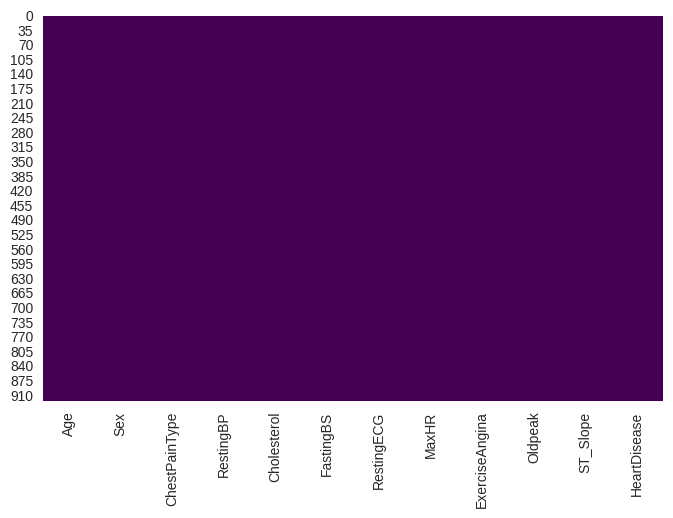

In [1016]:
plt.figure(figsize=(8,5))
sns.heatmap(heart.isnull(),cbar=False,cmap='viridis')

In [1017]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             923 non-null    int64  
 1   Sex             923 non-null    object 
 2   ChestPainType   923 non-null    object 
 3   RestingBP       923 non-null    int64  
 4   Cholesterol     923 non-null    int64  
 5   FastingBS       923 non-null    int64  
 6   RestingECG      923 non-null    object 
 7   MaxHR           923 non-null    int64  
 8   ExerciseAngina  923 non-null    object 
 9   Oldpeak         923 non-null    float64
 10  ST_Slope        923 non-null    object 
 11  HeartDisease    923 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.7+ KB


In [1018]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,53.527627,132.453954,199.034670,0.231853,136.819068,0.886024,0.551463
std,9.418220,18.497194,109.174326,0.422244,25.449426,1.064875,0.497614
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,174.500000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


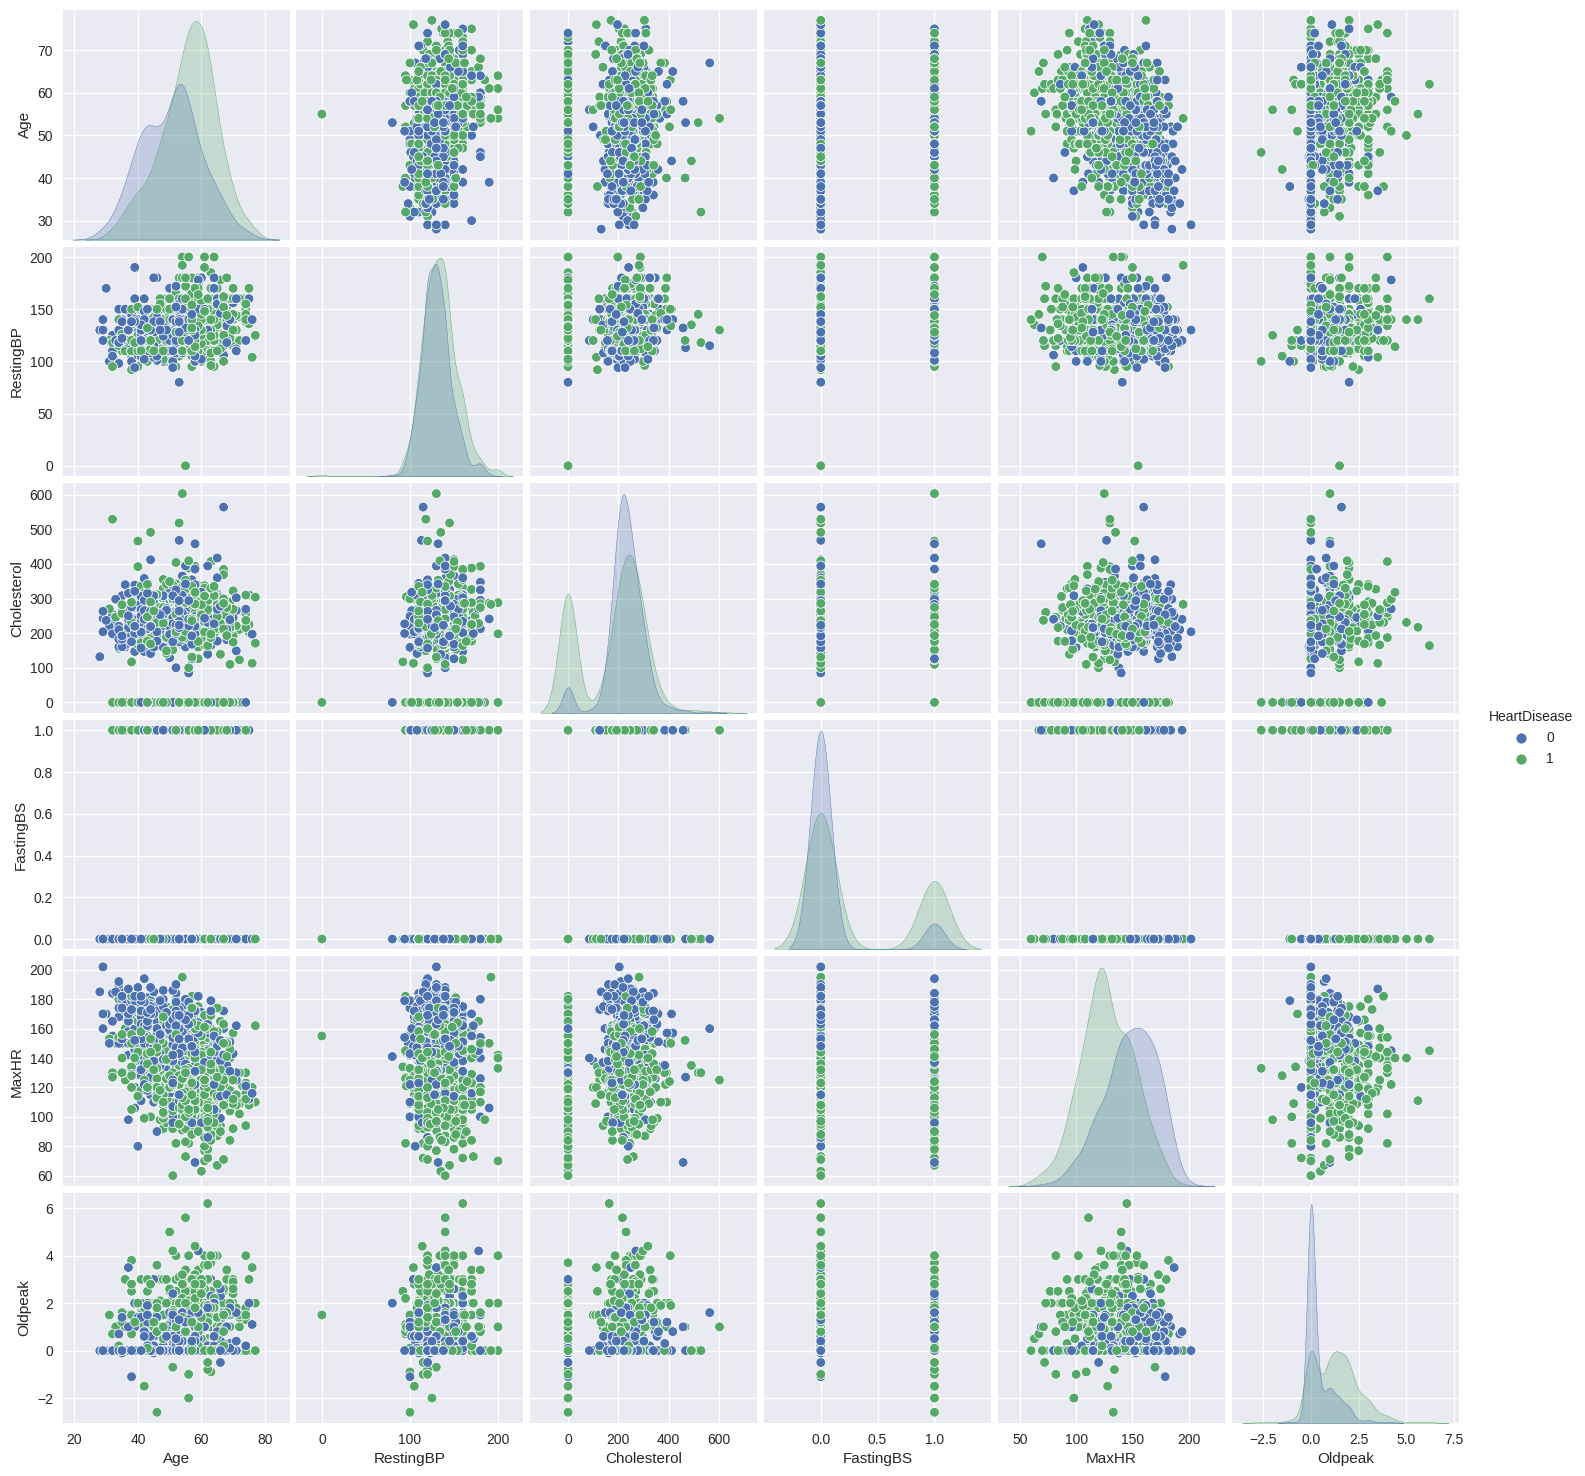

In [1019]:
#To find a relationship between variables
sns.pairplot(data=heart, hue='HeartDisease') 

ChestPainType contains 4 types which are : 
1. ATA
2. NAP
3. ASY
4. TA
5. TAA
----------------------------
Count for each type :::
ASY    498
NAP    205
ATA    174
TA      45
TAA      1
Name: ChestPainType, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of ChestPainType')

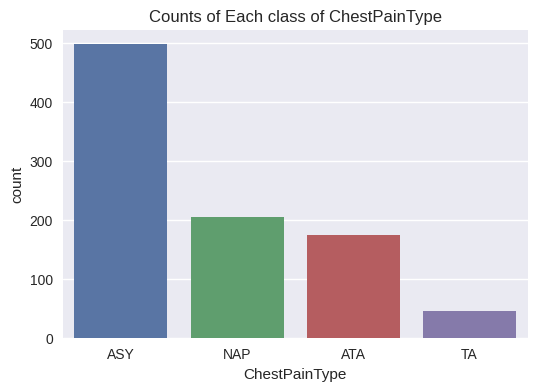

In [1020]:
# priting the types of chestpaintype and it's count and visually with countplot
print("ChestPainType contains 4 types which are : ")
i=1
for x in heart['ChestPainType'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart['ChestPainType'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart['ChestPainType'], order= ['ASY','NAP','ATA','TA'])
plt.title("Counts of Each class of ChestPainType")

ST_Slope contains 3 types which are : 
1. Up
2. Flat
3. Down
----------------------------
Count for each type :::
Flat    463
Up      397
Down     63
Name: ST_Slope, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of ST_Slope')

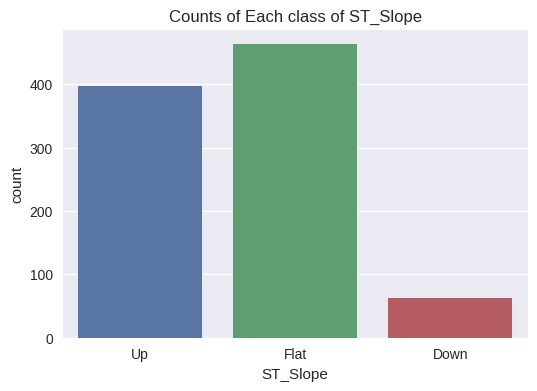

In [1021]:
# priting the types of ST_slope and it's count and visually with countplot
print("ST_Slope contains 3 types which are : ")
i=1
for x in heart['ST_Slope'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart['ST_Slope'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart['ST_Slope'])
plt.title("Counts of Each class of ST_Slope")

RestingECG contains 3 types which are : 
1. Normal
2. ST
3. LVH
----------------------------
Count for each type :::
Normal    554
LVH       191
ST        178
Name: RestingECG, dtype: int64
----------------------------
----------------------------


Text(0.5, 1.0, 'Counts of Each class of RestingECG')

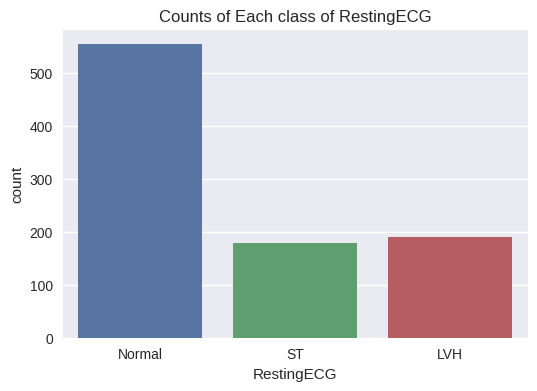

In [1022]:
# priting the types of RestingECG and it's count and visually with countplot
print("RestingECG contains 3 types which are : ")
i=1
for x in heart['RestingECG'].unique():
  print("{}. {}".format(i,x))
  i = i + 1
print("----------------------------")
print("Count for each type :::")
print(heart['RestingECG'].value_counts())
print("----------------------------")
print("----------------------------")
plt.figure(figsize = (6,4))
sns.countplot(x=heart['RestingECG'])
plt.title("Counts of Each class of RestingECG")

In [1023]:
# To hold the boolean values in binary_variables
binary_variables = ['Sex','FastingBS','ExerciseAngina','HeartDisease'] 

for variable in binary_variables:
  print("Count for each type of {} :::".format(variable))
  print(heart[variable].value_counts())
  print("----------------------------")

Count for each type of Sex :::
M    728
F    195
Name: Sex, dtype: int64
----------------------------
Count for each type of FastingBS :::
0    709
1    214
Name: FastingBS, dtype: int64
----------------------------
Count for each type of ExerciseAngina :::
N    551
Y    372
Name: ExerciseAngina, dtype: int64
----------------------------
Count for each type of HeartDisease :::
1    509
0    414
Name: HeartDisease, dtype: int64
----------------------------


# ***Exploratory Data Analysis***

<ipython-input-1024-9d9fc6ed2526>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

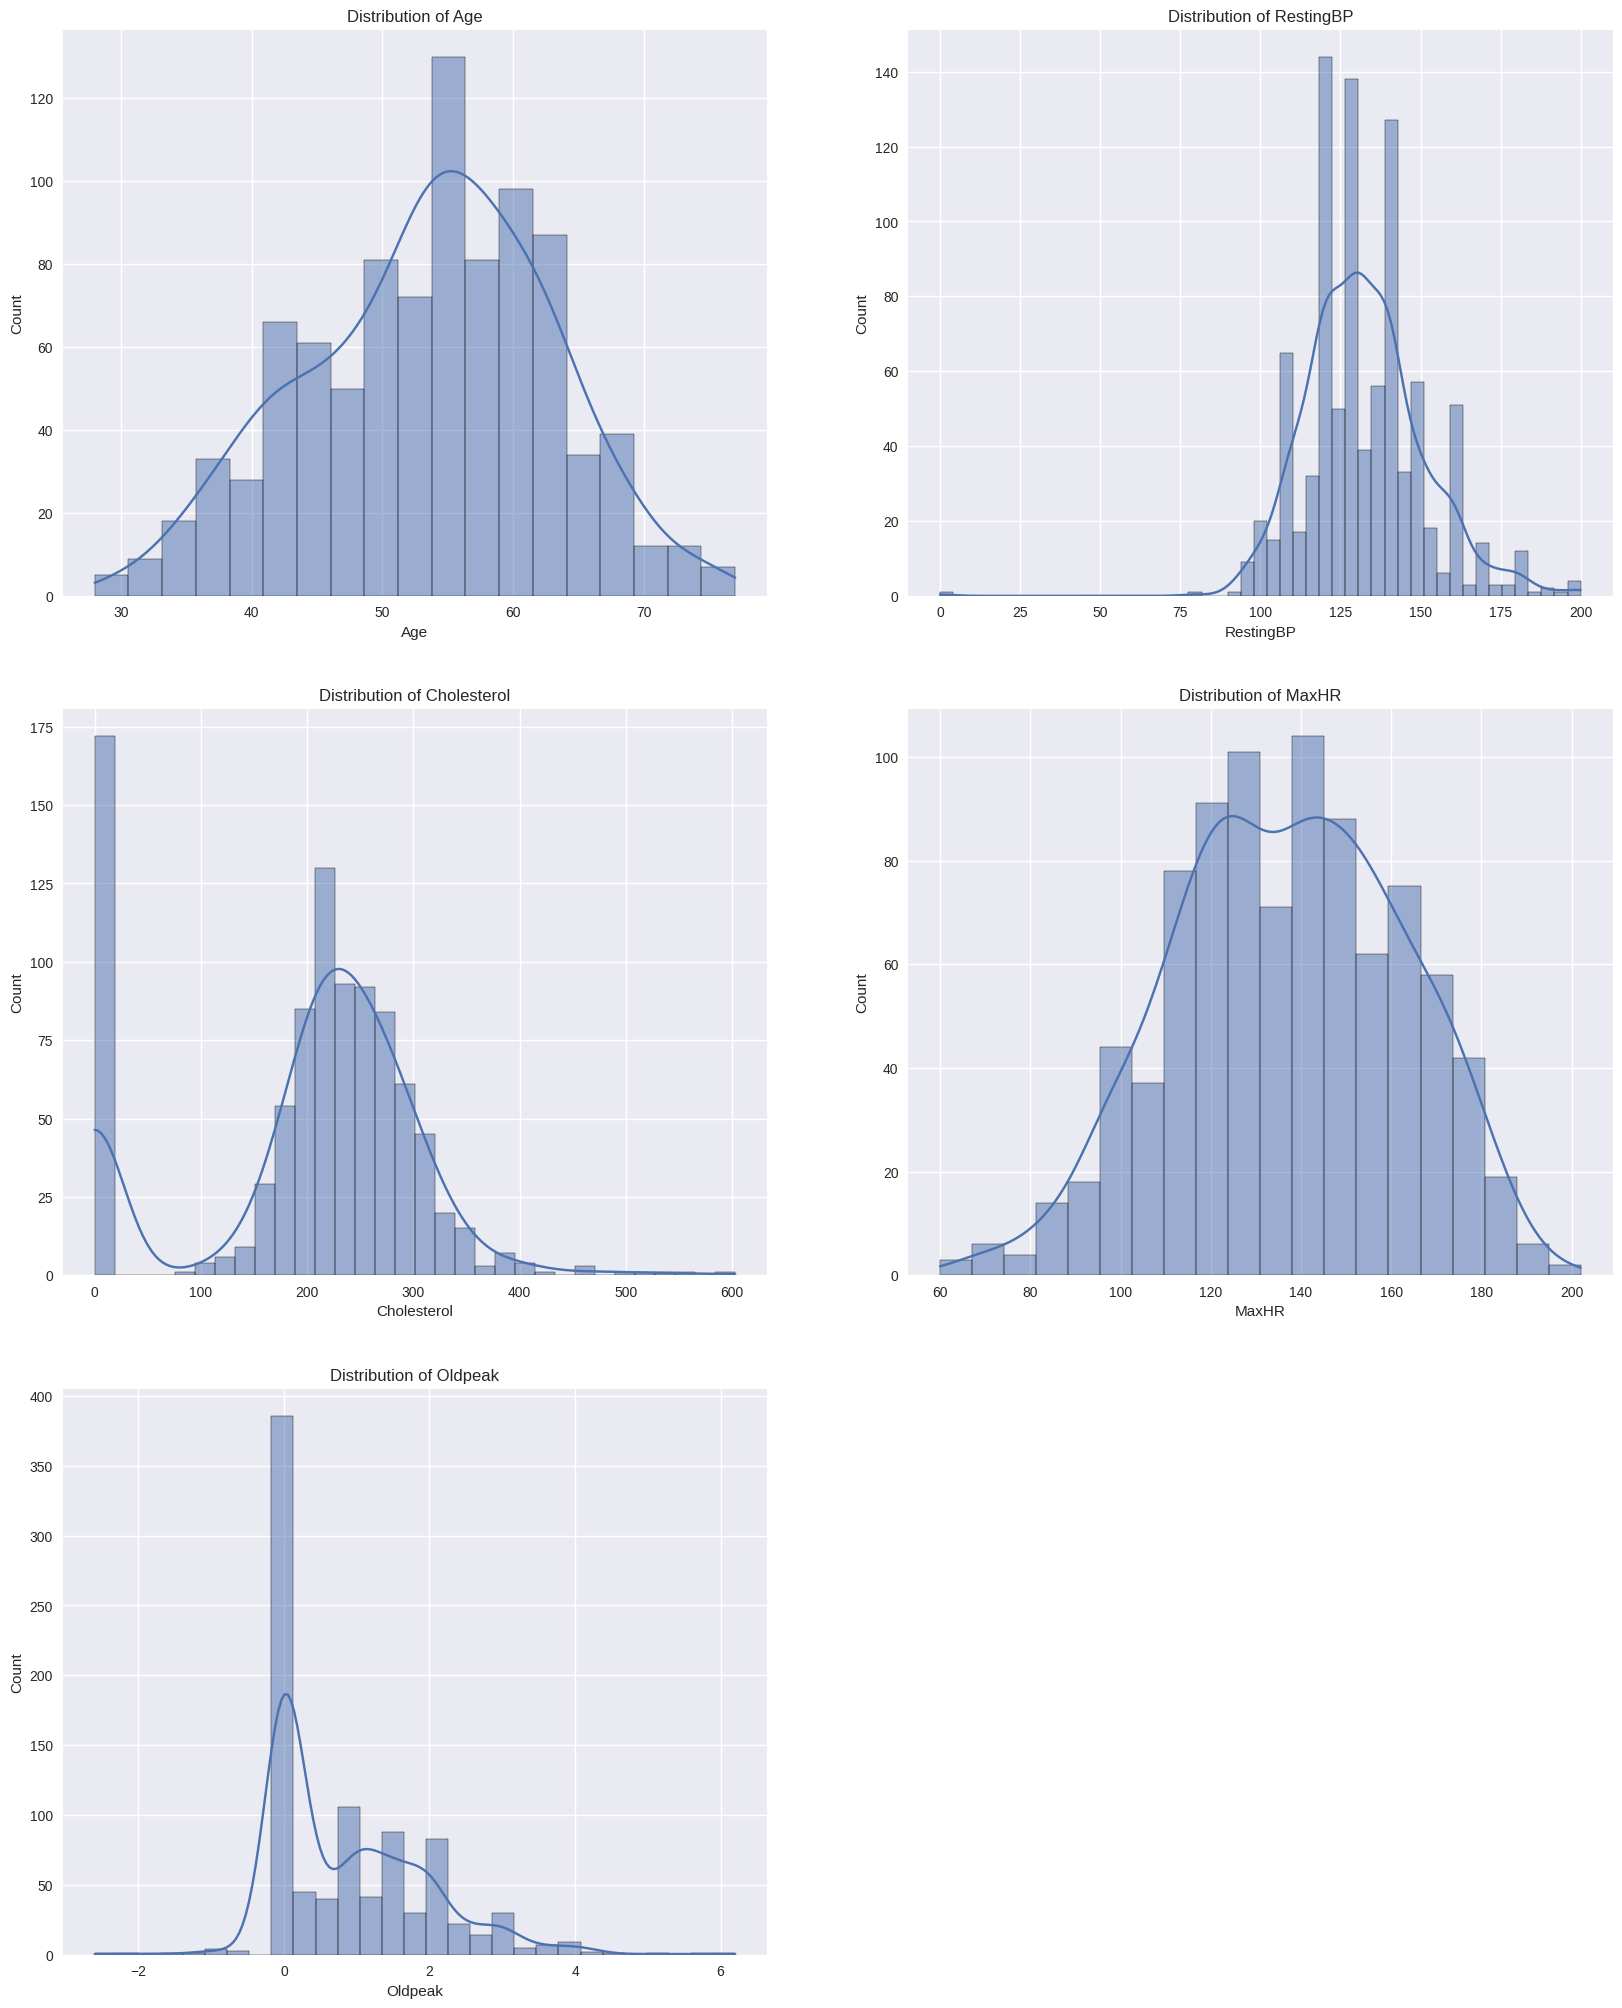

In [1024]:
#to hold the numerical values in variable numerical_variables and create a histogram to check the normality of variables
numerical_variables = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
plt.style.use("seaborn")
plt.subplots_adjust(top=0.9,hspace=6,wspace = 1)
plt.figure(figsize=(20,25))
plt.subplot(3,2,1)
i=1
for feature in heart.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.histplot(data=heart, x=feature, kde=True)
        plt.title("Distribution of {}".format(feature))
        i+=1

Text(0.5, 1.0, 'Distribution of HeartDisease')

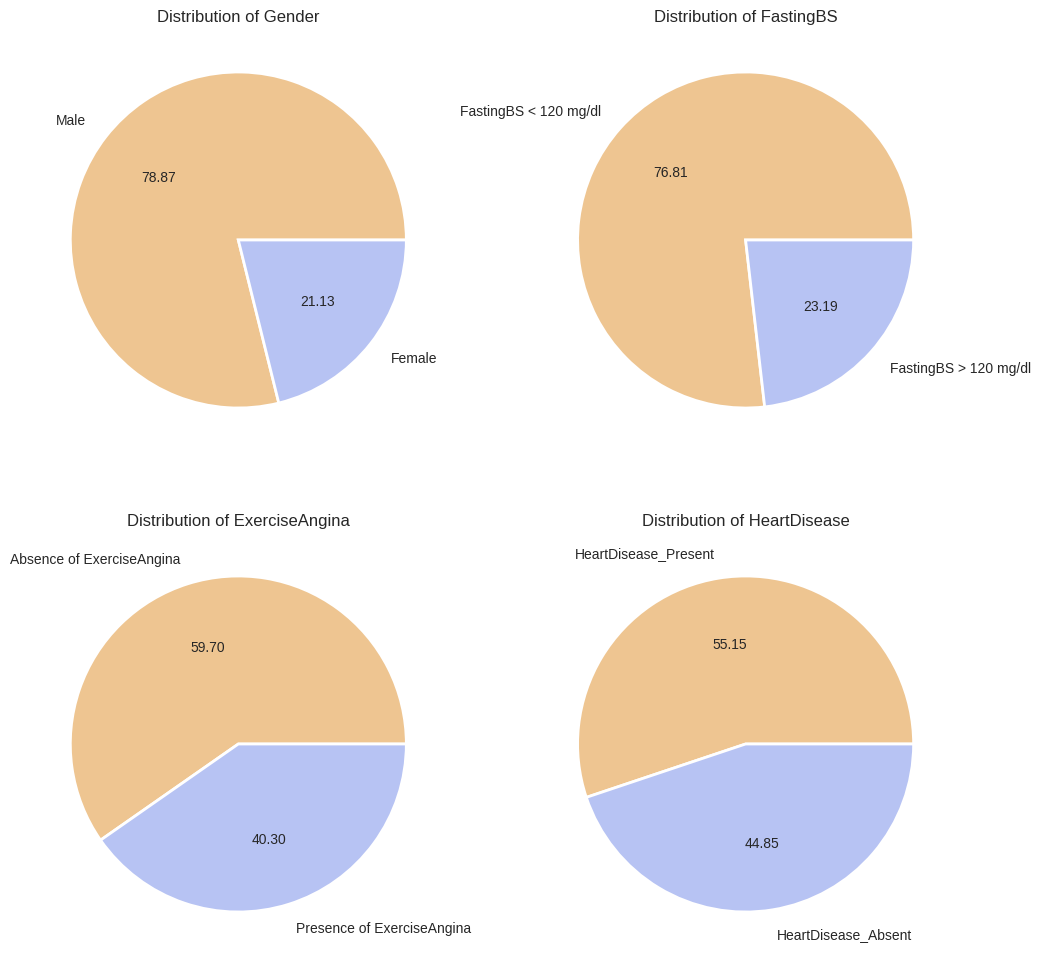

In [1025]:
#to hold the boolean values in variable binary_variables and create a pie chart for distribution
binary_variables = ['Sex','FastingBS','ExerciseAngina','HeartDisease'] 
colors = ['#EEC591', '#B7C3F3']
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
values = heart['Sex'].value_counts()
labels = ['Male','Female']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors, autopct= '%.2f');
plt.title("Distribution of Gender")
plt.subplot(2,2,2)
values = heart['FastingBS'].value_counts()
labels = ['FastingBS < 120 mg/dl','FastingBS > 120 mg/dl']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors, autopct= '%.2f');
plt.title("Distribution of FastingBS")
plt.subplot(2,2,3)
values = heart['ExerciseAngina'].value_counts()
labels = ['Absence of ExerciseAngina','Presence of ExerciseAngina']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors,autopct= '%.2f');
plt.title("Distribution of ExerciseAngina")
plt.subplot(2,2,4)
values = heart['HeartDisease'].value_counts() #'#4F6272', '#B7C3F3' 
labels = ['HeartDisease_Present','HeartDisease_Absent']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },colors = colors,autopct= '%.2f');
plt.title("Distribution of HeartDisease")

Text(0.5, 1.0, 'Counts of Chest pain types')

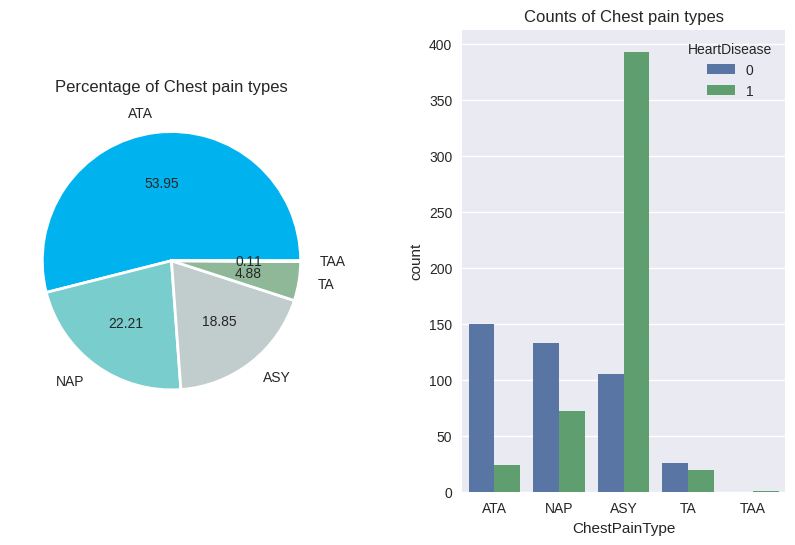

In [1026]:
values = heart['ChestPainType'].value_counts()
labels = heart['ChestPainType'].unique()
colors = ['#00B2EE', '#79CDCD', '#C1CDCD', '#8EB897']
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Percentage of Chest pain types")
plt.subplot(1,2,2)
sns.countplot(x=heart['ChestPainType'], hue=heart['HeartDisease'])
plt.title("Counts of Chest pain types")

Text(0.5, 1.0, 'Counts of ST_Slope')

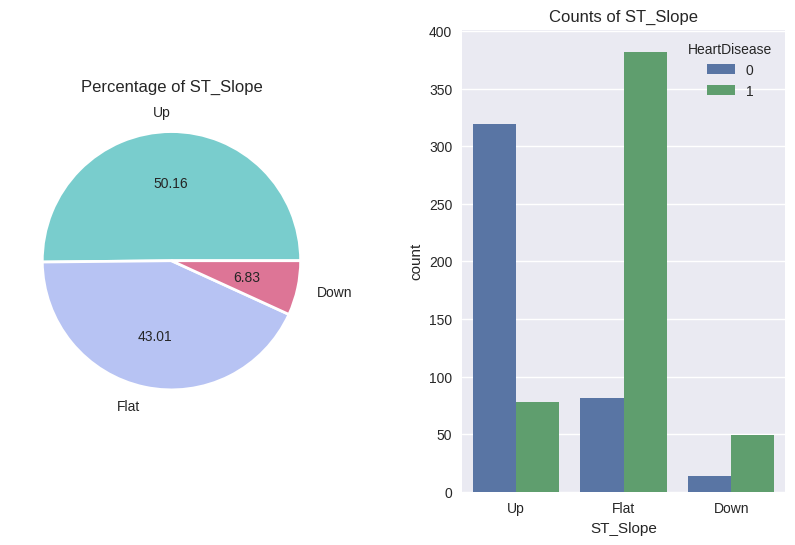

In [1027]:
values = heart['ST_Slope'].value_counts()
labels = heart['ST_Slope'].unique()
colors = ['#79CDCD', '#B7C3F3', '#DD7596', '#8EB897']
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Percentage of ST_Slope")
plt.subplot(1,2,2)
sns.countplot(x=heart['ST_Slope'], hue=heart['HeartDisease'])
plt.title("Counts of ST_Slope")

Text(0.5, 1.0, 'Counts of RestingECG classes')

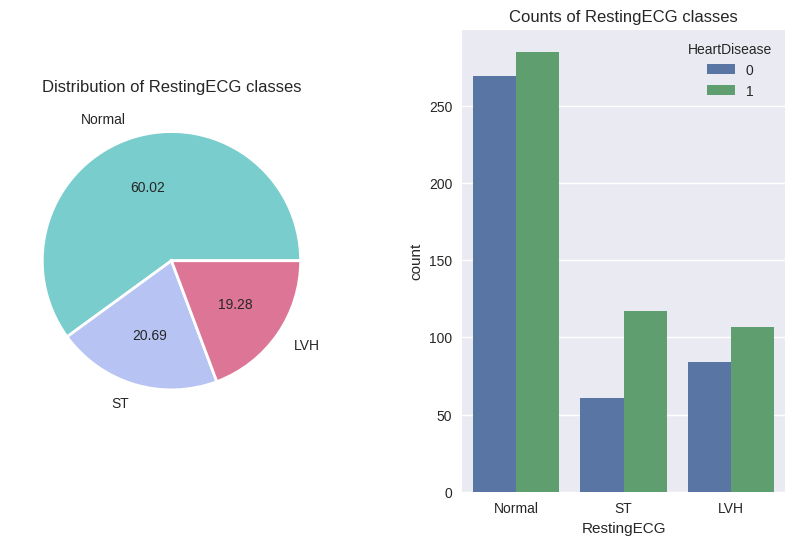

In [1028]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
values = heart['RestingECG'].value_counts()
labels = heart['RestingECG'].unique()
colors = ['#79CDCD', '#B7C3F3', '#DD7596', '#8EB897']
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, colors=colors,autopct= '%.2f');
plt.title("Distribution of RestingECG classes")
plt.subplot(1,2,2)
sns.countplot(x=heart['RestingECG'], hue=heart['HeartDisease'])
plt.title("Counts of RestingECG classes")

In [1029]:
pd.crosstab(heart['Sex'], [heart['FastingBS'], heart['ExerciseAngina'], heart['ChestPainType'], heart['ST_Slope'], heart['RestingECG']])

FastingBS         0                                             ...      1     \
ExerciseAngina    N                                             ...      Y      
ChestPainType   ASY                                     ATA     ...    ATA      
ST_Slope       Down    Flat            Up              Down     ...   Flat      
RestingECG      LVH ST  LVH Normal ST LVH Normal  ST Normal ST  ... Normal ST   
Sex                                                             ...             
F                 2  0    7      5  0   5      8   3      0  0  ...      0  0   
M                 0  2   10     37  3  11     35  10      2  1  ...      2  1   

FastingBS                                                    
ExerciseAngina                                               
ChestPainType              NAP                           TA  
ST_Slope        Up        Down Flat               Up   Flat  
RestingECG     LVH Normal   ST  LVH Normal ST Normal Normal  
Sex                                                          
F                1      1    0    0      0  0      0      0  
M                0      0    1    4      2  4      2      1  

[2 rows x 105 columns]

In [1030]:
#test to check the relationship between two categorial variables
from scipy.stats import chi2_contingency

# list of categorical variables
variables = ['Sex', 'FastingBS', 'ExerciseAngina', 'ChestPainType', 'ST_Slope', 'RestingECG']

# loop over each combination of variables
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        # contingency table of two categorical variables
        cont_table = pd.crosstab(heart[variables[i]], heart[variables[j]])
        
        # perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(cont_table)

        # print the results
        print(f"Chi-square test between {variables[i]} and {variables[j]}")
        print("Chi-square test statistic:", chi2)
        print("p-value:", p_value)
        print("\n")

Chi-square test between Sex and FastingBS
Chi-square test statistic: 12.781608880403454
p-value: 0.00035004374104376376


Chi-square test between Sex and ExerciseAngina
Chi-square test statistic: 33.277420857657205
p-value: 7.990504042866007e-09


Chi-square test between Sex and ChestPainType
Chi-square test statistic: 38.85077256856066
p-value: 7.478804945413114e-08


Chi-square test between Sex and ST_Slope
Chi-square test statistic: 21.920752470065082
p-value: 1.7376771149746674e-05


Chi-square test between Sex and RestingECG
Chi-square test statistic: 5.470480711062871
p-value: 0.0648784113446434


Chi-square test between FastingBS and ExerciseAngina
Chi-square test statistic: 3.2005037109667667
p-value: 0.07361559375029998


Chi-square test between FastingBS and ChestPainType
Chi-square test statistic: 24.343402089158623
p-value: 6.816151990580526e-05


Chi-square test between FastingBS and ST_Slope
Chi-square test statistic: 28.431539515417434
p-value: 6.701463217666277e-07


Ch

<ipython-input-1031-fd8dd52144ec>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

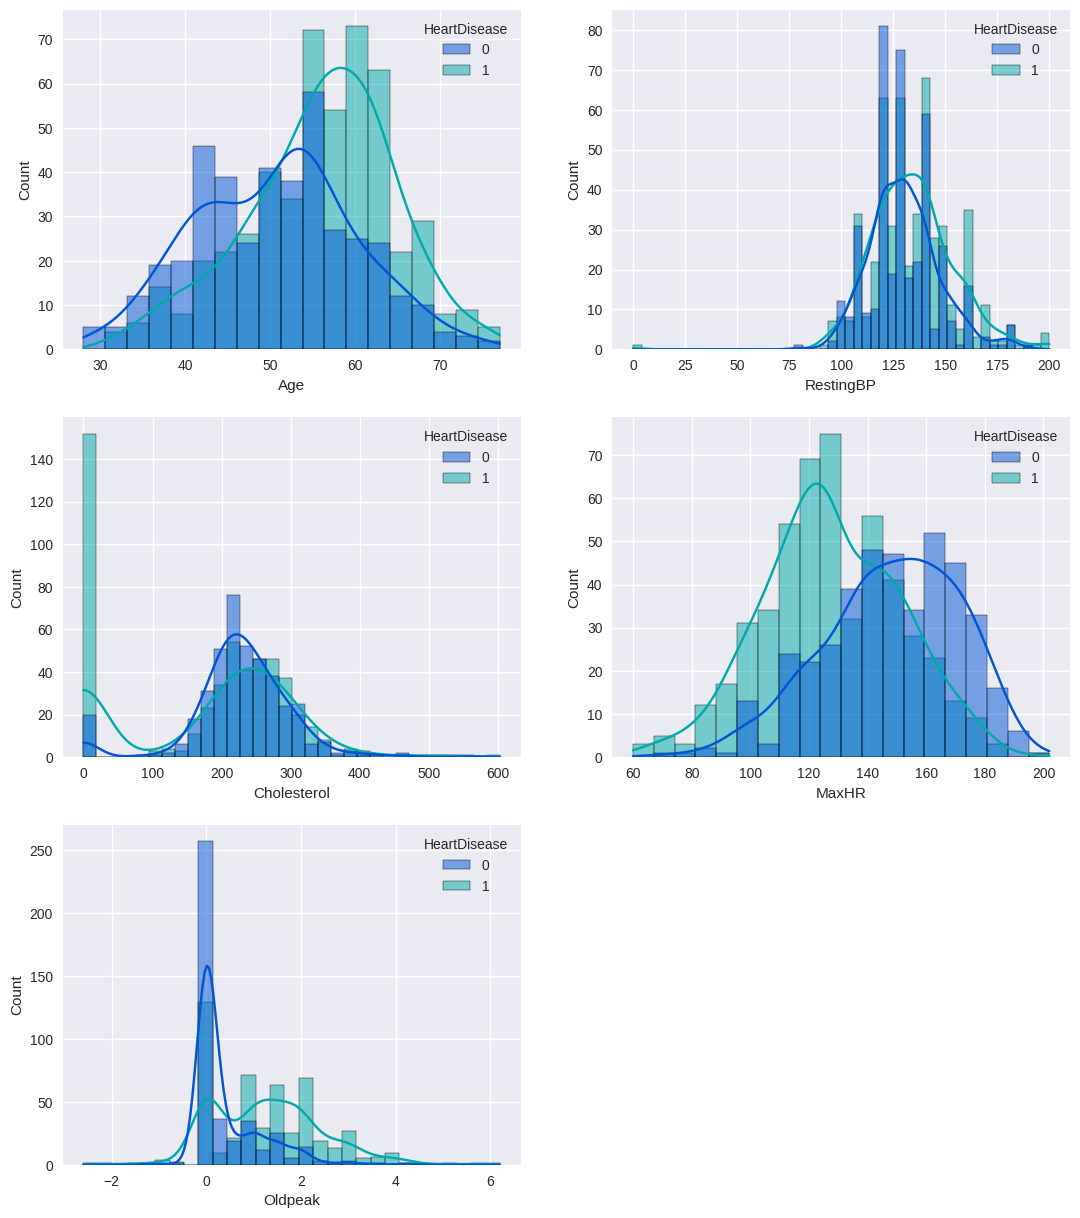

In [1031]:
numerical_variables = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in heart.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.histplot(data=heart, x=feature, kde=True, palette="winter", hue='HeartDisease')
        i+=1

<Axes: xlabel='HeartDisease', ylabel='Sex'>

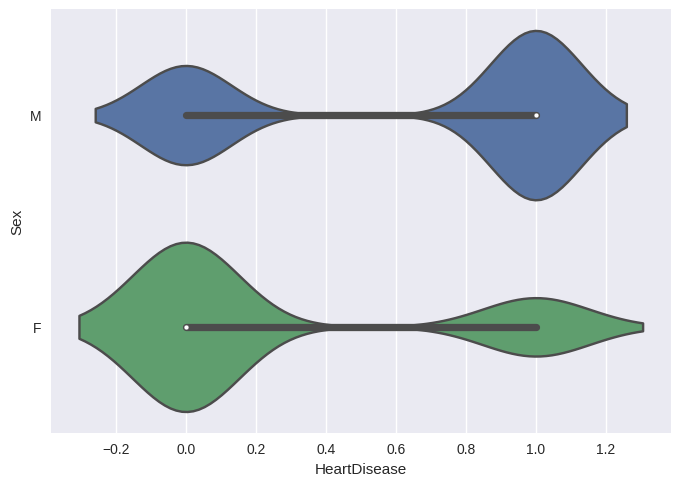

In [1032]:
sns.violinplot(x = heart['HeartDisease'] , y = heart['Sex']) # which specific gender is most likely to have heart Disease

Text(0.5, 1.0, 'Age vs Cholesterol')

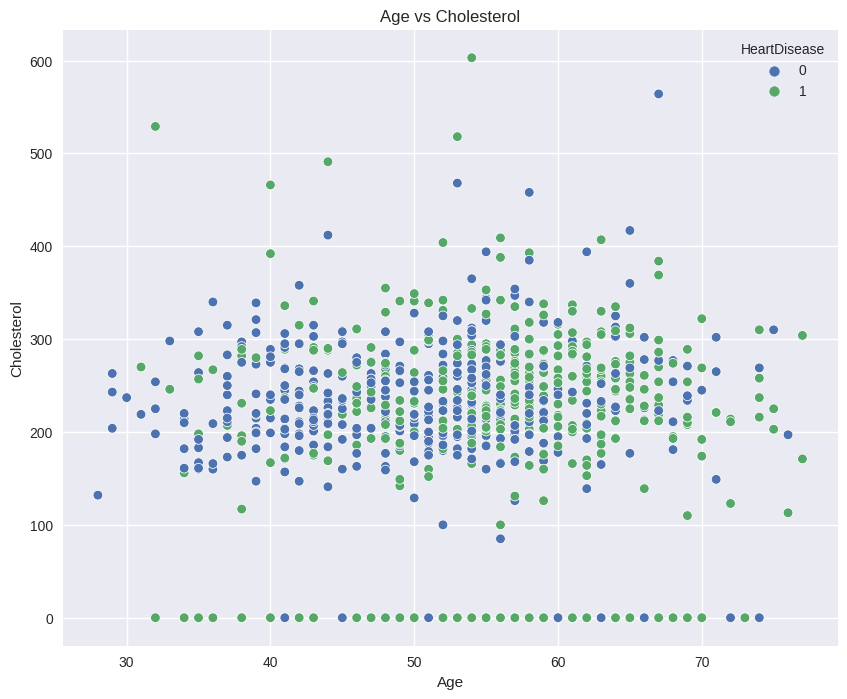

In [1033]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart["Age"], y=heart["Cholesterol"],hue = heart['HeartDisease']).set_title("Age vs Cholesterol")

Text(0.5, 1.0, 'Age vs MaxHR')

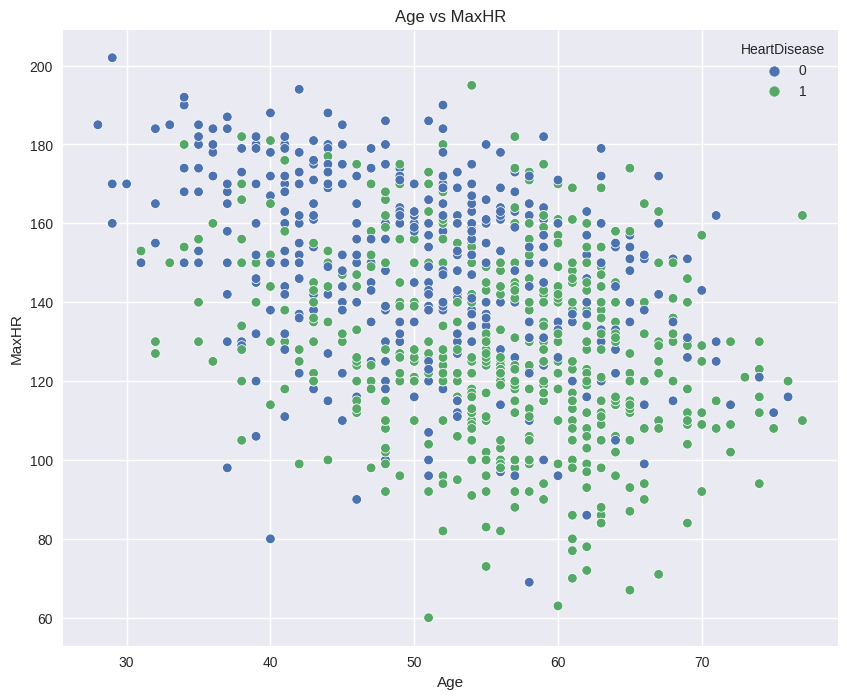

In [1034]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart["Age"], y=heart["MaxHR"],hue = heart['HeartDisease']).set_title("Age vs MaxHR")

Text(0.5, 1.0, 'Age vs RestingBP')

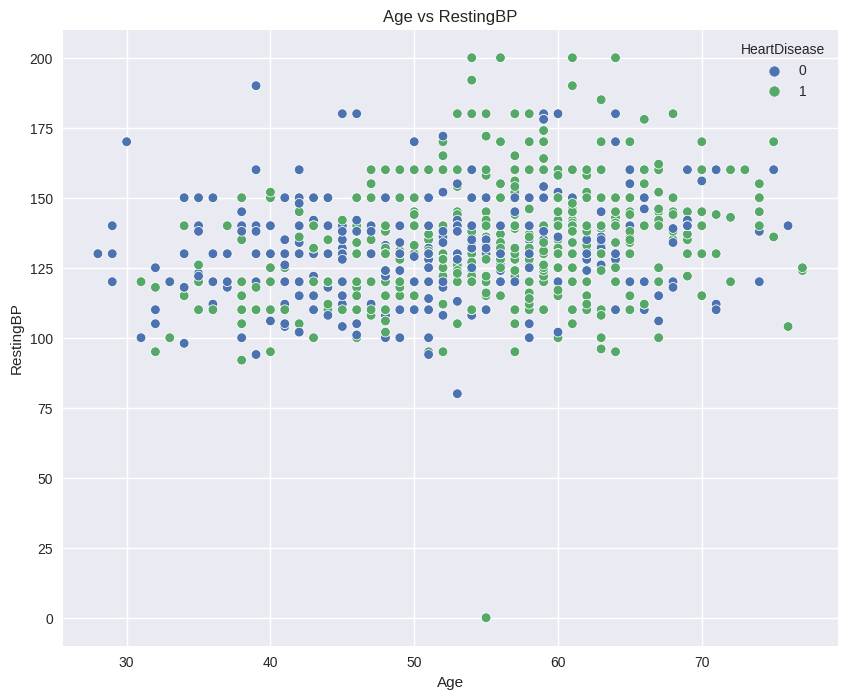

In [1035]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart["Age"], y=heart["RestingBP"],hue = heart['HeartDisease']).set_title("Age vs RestingBP")

Text(0.5, 1.0, 'Age vs Oldpeak')

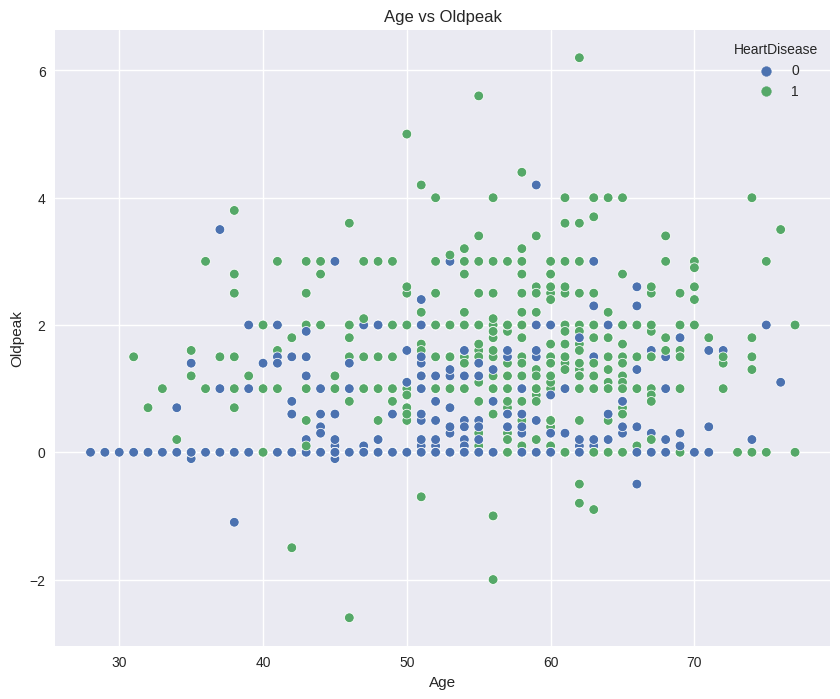

In [1036]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=heart["Age"], y=heart["Oldpeak"],hue = heart['HeartDisease']).set_title("Age vs Oldpeak")

#Detecting and Outliers

<ipython-input-1037-2deb27e14e85>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

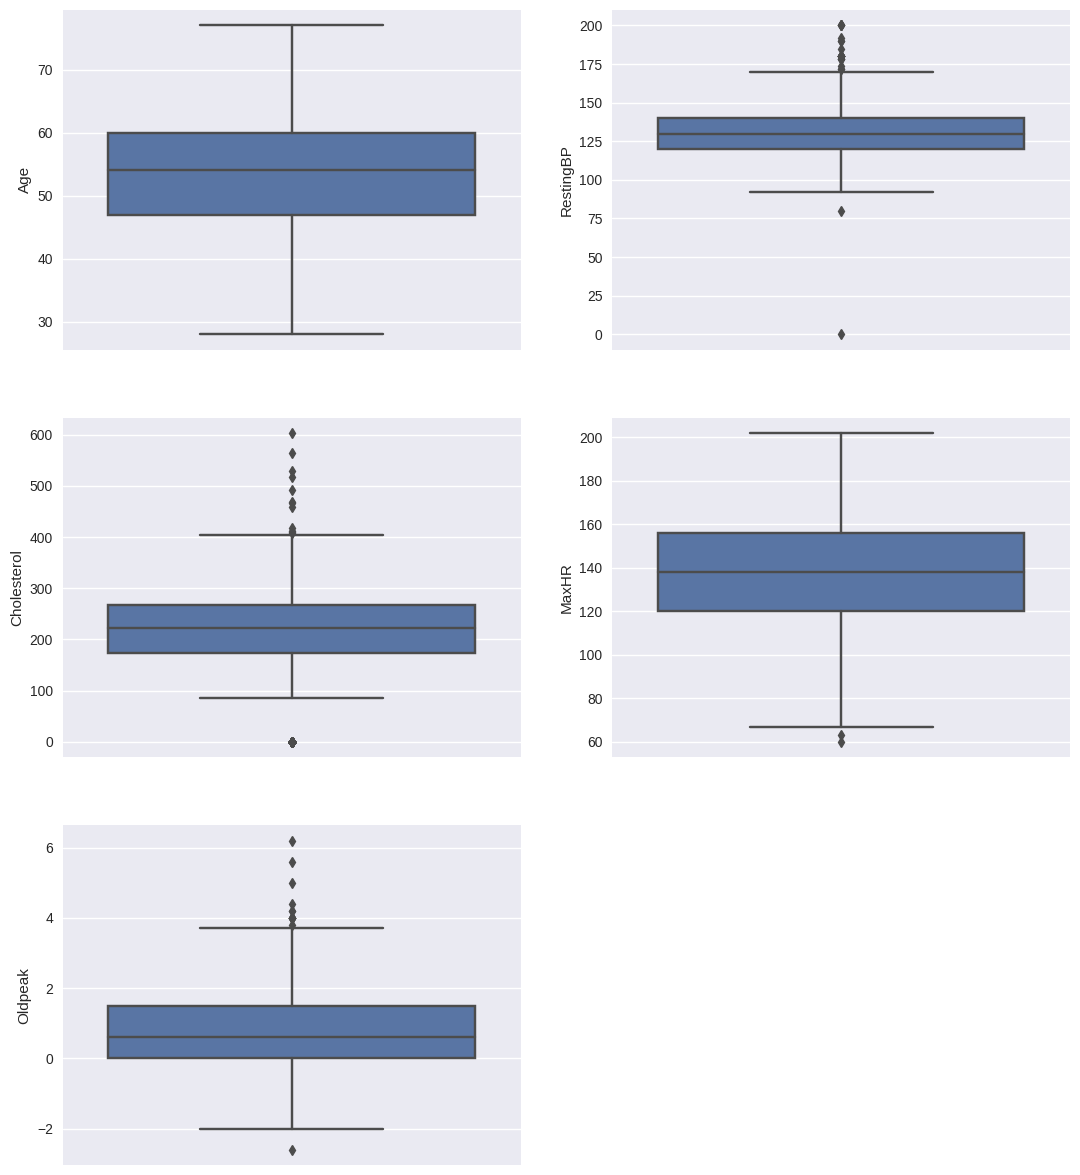

In [1037]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.6,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in heart.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.boxplot(y=heart[feature])
        i+=1

In [1038]:
temp = heart.copy()

In [1039]:
#shapiro test to check the normality on the basis hypothesis
for variable in numerical_variables:
  stat, p = stats.shapiro(temp[variable])

  alpha = 0.05
  if p > alpha:
      print('"{}" looks normally distributed (fail to reject H0)'.format(variable))
  else:
      print('"{}" does not look normally distributed (reject H0)'.format(variable))
  print(" ")

"Age" does not look normally distributed (reject H0)
 
"RestingBP" does not look normally distributed (reject H0)
 
"Cholesterol" does not look normally distributed (reject H0)
 
"MaxHR" does not look normally distributed (reject H0)
 
"Oldpeak" does not look normally distributed (reject H0)
 


In [1040]:
# Calculate the IQR of the data
Q1 = temp['Cholesterol'].quantile(0.25)
Q3 = temp['Cholesterol'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower bounds for outliers
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

# Identify the outliers in the dataframe
outliers = temp[(temp['Cholesterol'] < lower_bound) | (temp['Cholesterol'] > upper_bound)].dropna()

# Delete the outliers from the dataframe
temp= temp.drop(outliers.index)

In [1041]:
Q1 = temp['Oldpeak'].quantile(0.25)
Q3 = temp['Oldpeak'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['Oldpeak'] < lower_bound) | (temp['Oldpeak'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [1042]:
Q1 = temp['RestingBP'].quantile(0.25)
Q3 = temp['RestingBP'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['RestingBP'] < lower_bound) | (temp['RestingBP'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [1043]:
Q1 = temp['MaxHR'].quantile(0.25)
Q3 = temp['MaxHR'].quantile(0.75)
IQR = Q3 - Q1


upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['MaxHR'] < lower_bound) | (temp['MaxHR'] > upper_bound)].dropna()

temp= temp.drop(outliers.index)

In [1044]:
Q1 = temp['Age'].quantile(0.25)
Q3 = temp['Age'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR

outliers = temp[(temp['Age'] < lower_bound) | (temp['Age'] > upper_bound)].dropna()

outliers.shape 

(0, 12)

After Removing Outliers

<ipython-input-1045-2deb27e14e85>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<Figure size 800x550 with 0 Axes>

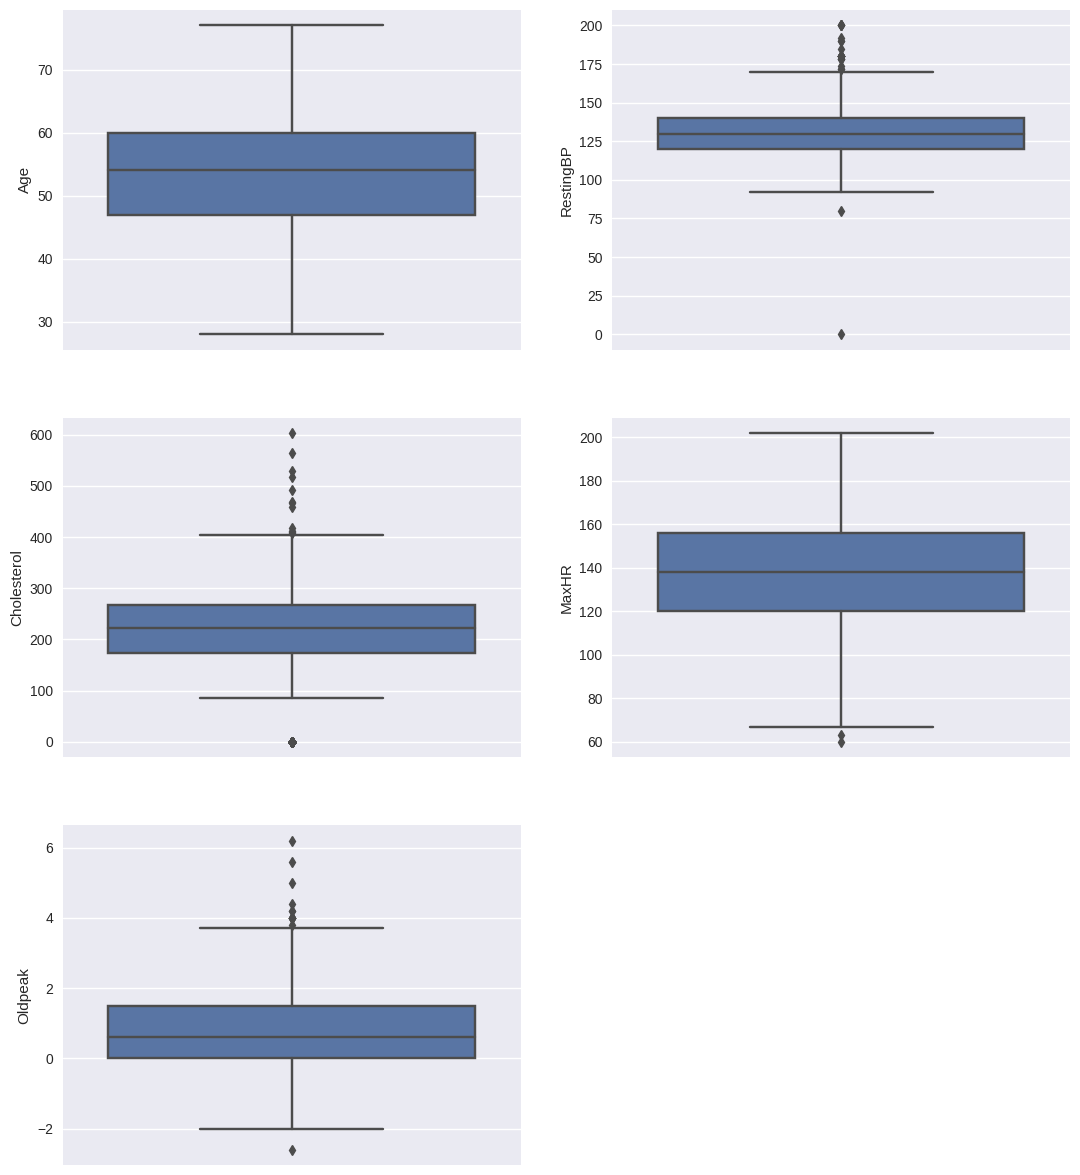

In [1045]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.6,wspace = 0.4)
plt.figure(figsize=(13,15))
plt.subplot(3,2,1)
i=1
for feature in heart.columns:
    if feature  in numerical_variables :
        plt.subplot(3,2,i)
        sns.boxplot(y=heart[feature])
        i+=1

In [1046]:
#data after removing outliers
temp.shape

(707, 12)

<Figure size 2000x4000 with 0 Axes>

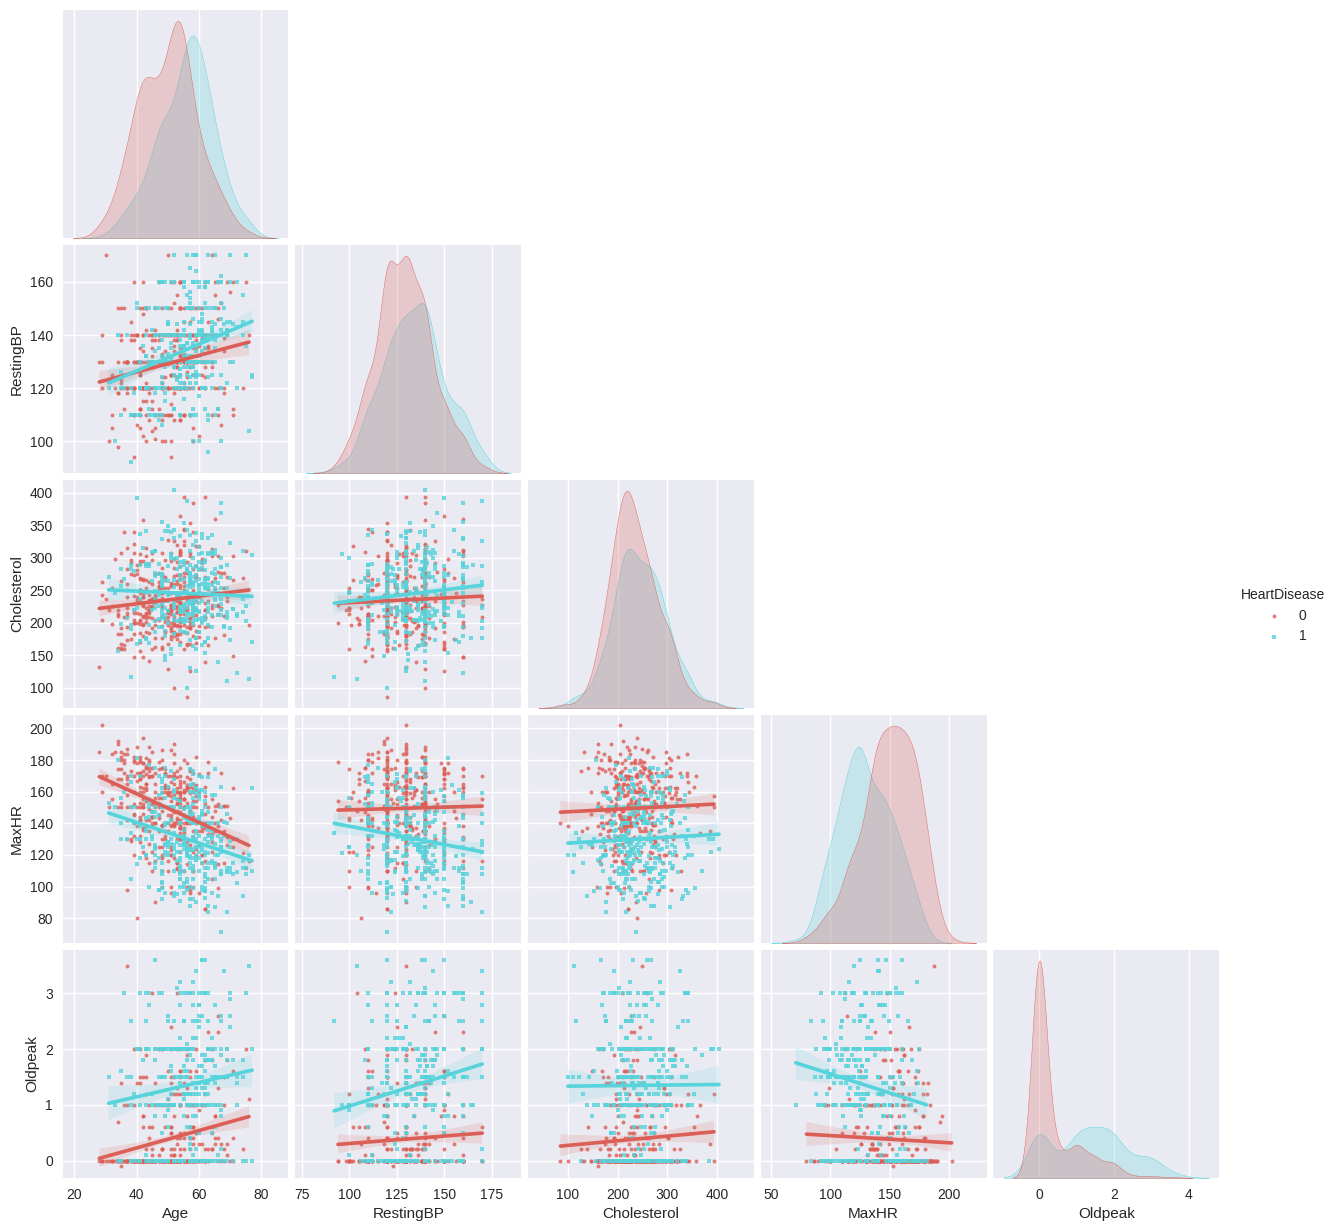

In [1047]:
plt.figure(figsize=(20,40))
sns.pairplot(data=temp[numerical_variables + ["HeartDisease"]], hue="HeartDisease", palette='hls', kind="reg", corner=True, markers=["o", "s"], plot_kws={ 'scatter_kws': {'alpha': 0.8, 's':8}})

In [1048]:
#OneHotEncoder to convert the categorical data into numerical format
one_hot_encoder= OneHotEncoder(sparse = False)   
one_hot_encoder.fit_transform(temp[['ChestPainType']])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [1049]:
encoded_data = pd.get_dummies(temp, columns = ['Sex','ExerciseAngina','FastingBS','ST_Slope','ChestPainType','RestingECG'],drop_first=True)

Text(0.5, 1.0, 'Data correlations')

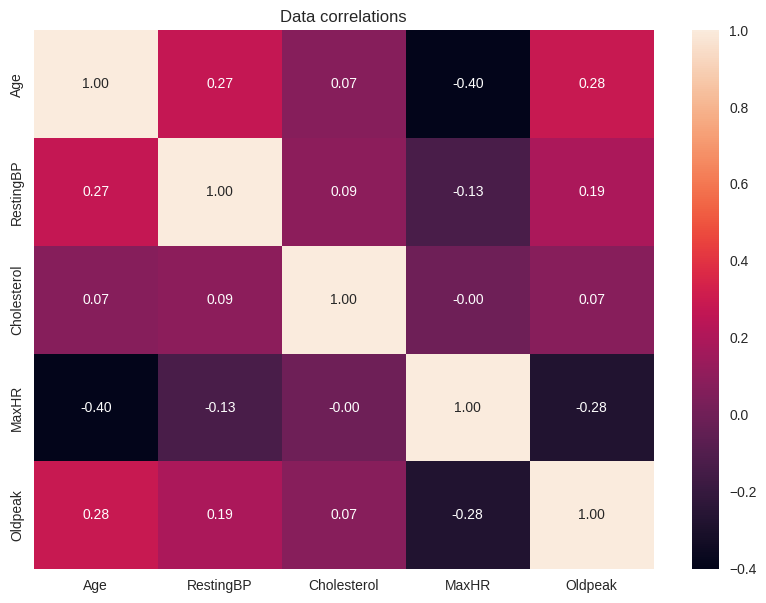

In [1050]:
correlation=encoded_data[numerical_variables].corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation,annot=True,fmt='.2f',annot_kws={'size': 10})
plt.title("Data correlations")

In [1051]:
temp_data = encoded_data.copy()
names = temp_data.columns
names

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease',
       'Sex_M', 'ExerciseAngina_Y', 'FastingBS_1', 'ST_Slope_Flat',
       'ST_Slope_Up', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'ChestPainType_TAA', 'RestingECG_Normal',
       'RestingECG_ST'],
      dtype='object')

In [1052]:
#for dependent and independent variables for training the model
X = encoded_data.drop('HeartDisease', axis = 1)
y = encoded_data[['HeartDisease']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [1054]:
#SelectKBest is a feature selection method in machine learning used to select the top K most important features from a dataset
def featureSelect_dataframe(X, y, criteria, k):
  reg = SelectKBest(criteria, k=k).fit(X,y)
  X_transformed = reg.transform(X)
  X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]
  return X

New_X = featureSelect_dataframe(X_train, y_train, f_classif, 4)

New_X

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Oldpeak,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
164,0.0,0,0,1
222,0.0,0,0,1
276,2.0,0,1,0
623,1.2,0,1,0
805,1.2,0,0,1
...,...,...,...,...
75,0.0,0,0,1
113,0.0,0,0,1
287,0.0,0,0,1
634,1.4,1,0,1


In [1055]:
#standardizing the features 
scaler = StandardScaler()
#dimensionality reduction.
pca = PCA(0.95)

In [1056]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test) 

In [1057]:
PCA_X_train = pca.fit_transform(scaled_X_train)
PCA_X_test = pca.transform(scaled_X_test)

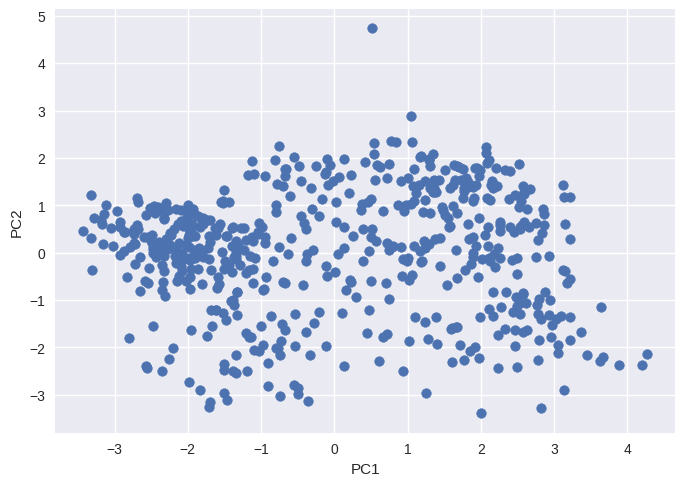

In [1058]:
plt.scatter(PCA_X_train[:, 0], PCA_X_train[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [1059]:
PCA_X_train.shape

(565, 14)

#Maching Learning Alogrithms Modeling With Normal Dataset

In [1060]:
dtree=DecisionTreeClassifier(random_state=42)

In [1061]:
t0 = dt.now()

In [1062]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [1063]:
t1 = dt.now()

In [1064]:
print("Time taken for training model for normal dataset:", (t1-t0).seconds)

Time taken for training model for normal dataset: 0


In [1065]:
pred=dtree.predict(X_test)

Confusion Matrix:
[[62  9]
 [10 61]]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        71
           1       0.87      0.86      0.87        71

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



Accuracy: 0.8661971830985915


Precision: 0.8714285714285714
Recall: 0.8591549295774648
f1 score: 0.8591549295774648
0.8661971830985915


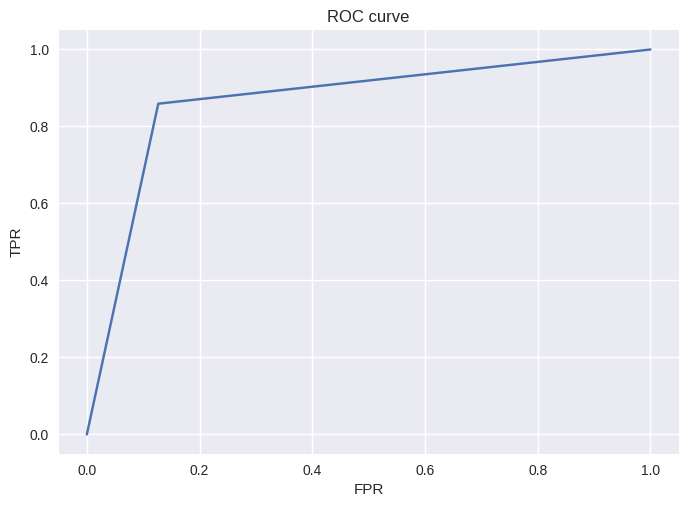

In [1066]:
result = confusion_matrix(y_test, pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,pred)
print("Accuracy:",result2)
print('\n')
f1score = f1_score(y_test, pred)

# calculate precision and recall scores
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)


print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#Maching Learning Alogrithms Modeling With Dimensionality Reduction(PCA)

In [1067]:
dtree_2 = DecisionTreeClassifier(random_state=42)

In [1068]:
t0 = dt.now()

In [1069]:
dtree_2 = dtree_2.fit(PCA_X_train,y_train)

In [1070]:
t1 = dt.now()

In [1071]:
print("Time taken for training model for PCA:", (t1-t0).seconds)

Time taken for training model for PCA: 0


In [1072]:
y_pred = dtree_2.predict(PCA_X_test)

Confusion Matrix:
[[62  9]
 [17 54]]


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83        71
           1       0.86      0.76      0.81        71

    accuracy                           0.82       142
   macro avg       0.82      0.82      0.82       142
weighted avg       0.82      0.82      0.82       142



Accuracy: 0.8169014084507042


Precision: 0.8571428571428571
Recall: 0.7605633802816901
f1 score: 0.7605633802816901
0.8661971830985915


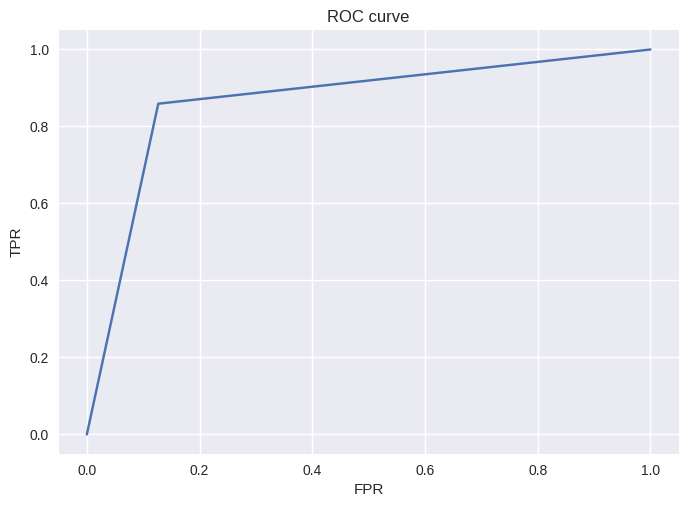

In [1073]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, pred)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#Maching Learning Alogrithms Modeling With Standard Scaler

In [1074]:
dtree_3 = DecisionTreeClassifier(random_state=42)

In [1075]:
t0 = dt.now()

In [1076]:
dtree_3 = dtree_3.fit(scaled_X_train,y_train)

In [1077]:
t1 = dt.now()

In [1078]:
print("Time taken for training model for standard scaler:", (t1-t0).seconds)

Time taken for training model for standard scaler: 0


In [1079]:
y_pred = dtree_3.predict(scaled_X_test)

Confusion Matrix:
[[62  9]
 [10 61]]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        71
           1       0.87      0.86      0.87        71

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



Accuracy: 0.8661971830985915


Precision: 0.8714285714285714
Recall: 0.8591549295774648
f1 score: 0.8591549295774648
0.8661971830985915


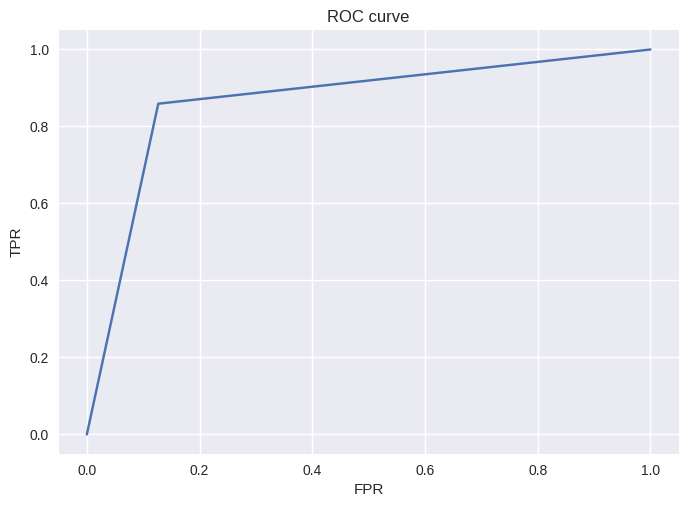

In [1080]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, pred)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#Hyperparamter tuning using GridSearchCV


In [1081]:
from sklearn.model_selection import GridSearchCV

param_grid =  {'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    
}
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15]},
             verbose=True)

In [1082]:
    print('Best Criterion:', grid_search.best_estimator_.get_params()['criterion'])
    print('Best max_depth:', grid_search.best_estimator_.get_params()['max_depth'])
    print('Best Number Of Components:', grid_search.best_estimator_.get_params()['min_samples_split'])
    print('Best Number Of Components:', grid_search.best_estimator_.get_params()['min_samples_leaf'])
    print(grid_search.best_estimator_)

Best Criterion: gini
Best max_depth: 10
Best Number Of Components: 5
Best Number Of Components: 10
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=5)


#Model with best parameters after GridSearchCV


In [1083]:
dtree_4 = DecisionTreeClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=5)
t0 = dt.now()

In [1084]:
dtree_4 = dtree_4.fit(X_train,y_train)
t1 = dt.now()

In [1085]:
print((t1-t0).seconds)

0


Confusion Matrix:
[[62  9]
 [10 61]]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        71
           1       0.87      0.86      0.87        71

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



Accuracy: 0.8661971830985915


Precision: 0.8714285714285714
Recall: 0.8591549295774648
f1 score: 0.8591549295774648
0.8661971830985915


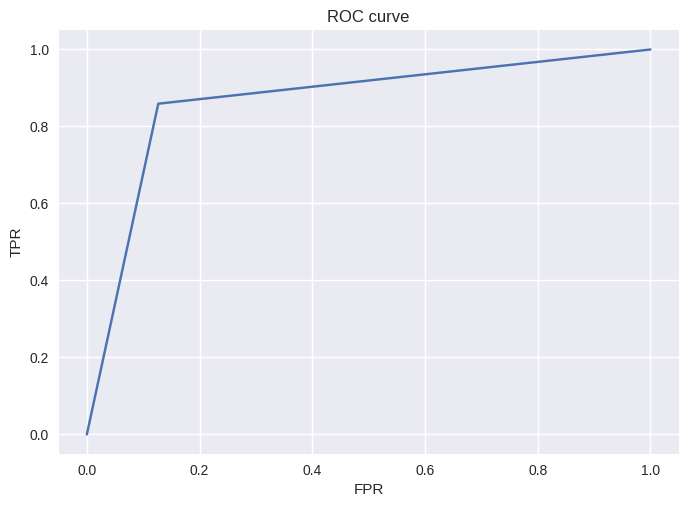

In [1086]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, pred)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#Random Tree Modeling


In [1087]:
random_tree=RandomForestClassifier(n_estimators = 300, max_depth = 4, max_features = 3, bootstrap = False, random_state = 42)
t0 = dt.now()

In [1088]:
random_tree.fit(scaled_X_train,y_train)
t1 = dt.now()

<ipython-input-1088-c53f909dde07>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_tree.fit(scaled_X_train,y_train)


In [1089]:
print((t1-t0).seconds)

0


In [1090]:
random_tree_pred=random_tree.predict(scaled_X_test)

Confusion Matrix:
[[62  9]
 [10 61]]


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87        71
           1       0.87      0.86      0.87        71

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



Accuracy: 0.8661971830985915


Precision: 0.8714285714285714
Recall: 0.8591549295774648
f1 score: 0.8591549295774648
0.8661971830985915


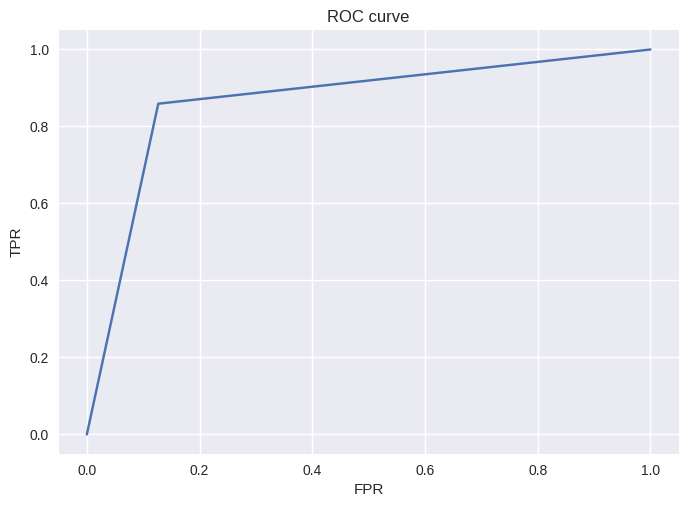

In [1091]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, pred)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#Implementing using HPC


In [1092]:
heart_final.to_csv('drive/My Drive/Datasets/heart_disease_final.csv', index=False)

In [1095]:
#to create an instance of pyspark
spark = SparkSession.builder\
 .master("local[*]")\
 .appName("Heart Disease Analysis")\
 .getOrCreate()
sc = spark.sparkContext

In [1096]:
heart = spark.read.csv('drive/My Drive/Datasets/heart_disease_final.csv', header = True, inferSchema = True)

In [1097]:
heart.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [1100]:
#converting categorical variables into numerical values
from pyspark.ml.feature import StringIndexer

In [1101]:
indexer=StringIndexer(inputCols=["Sex","RestingECG","ExerciseAngina","ST_Slope", "ChestPainType"],outputCols=["Sex_indexed","RestingECG_indexed","ExerciseAngina_indexed","ST_Slope_indexed","ChestPainType_indexed"])
heart_indexed=indexer.fit(heart).transform(heart)
heart_indexed.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+-----------+------------------+----------------------+----------------+---------------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|Sex_indexed|RestingECG_indexed|ExerciseAngina_indexed|ST_Slope_indexed|ChestPainType_indexed|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+-----------+------------------+----------------------+----------------+---------------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|        0.0|               0.0|                   0.0|             1.0|                  2.0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|        1.0|               0.0|        

In [1102]:
heart_indexed.columns

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease',
 'Sex_indexed',
 'RestingECG_indexed',
 'ExerciseAngina_indexed',
 'ST_Slope_indexed',
 'ChestPainType_indexed']

In [1103]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Age','Sex_indexed','ChestPainType_indexed','RestingBP','Cholesterol','FastingBS','RestingECG_indexed','MaxHR','ExerciseAngina_indexed','Oldpeak','ChestPainType_indexed'], outputCol="Independent_features")
output=assembler.transform(heart_indexed)

In [1104]:
output.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+-----------+------------------+----------------------+----------------+---------------------+--------------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|Sex_indexed|RestingECG_indexed|ExerciseAngina_indexed|ST_Slope_indexed|ChestPainType_indexed|Independent_features|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+-----------+------------------+----------------------+----------------+---------------------+--------------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|        0.0|               0.0|                   0.0|             1.0|                  2.0|(11,[0,2,3,4,7,10...|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|

In [1105]:
output.select('Independent_features').show()

+--------------------+
|Independent_features|
+--------------------+
|(11,[0,2,3,4,7,10...|
|[49.0,1.0,1.0,160...|
|[37.0,0.0,2.0,130...|
|[48.0,1.0,0.0,138...|
|(11,[0,2,3,4,7,10...|
|(11,[0,2,3,4,7,10...|
|[45.0,1.0,2.0,130...|
|(11,[0,2,3,4,7,10...|
|(11,[0,3,4,7,8,9]...|
|[48.0,1.0,2.0,120...|
|[37.0,1.0,1.0,130...|
|[58.0,0.0,2.0,136...|
|(11,[0,2,3,4,7,10...|
|(11,[0,3,4,7,8,9]...|
|[42.0,1.0,1.0,115...|
|[54.0,1.0,2.0,120...|
|(11,[0,3,4,7],[38...|
|[43.0,1.0,2.0,120...|
|(11,[0,3,4,7,9],[...|
|[36.0,0.0,2.0,120...|
+--------------------+
only showing top 20 rows



In [1106]:
finalized_data=output.select('Independent_features',"HeartDisease")

In [1107]:
finalized_data.show()

+--------------------+------------+
|Independent_features|HeartDisease|
+--------------------+------------+
|(11,[0,2,3,4,7,10...|           0|
|[49.0,1.0,1.0,160...|           1|
|[37.0,0.0,2.0,130...|           0|
|[48.0,1.0,0.0,138...|           1|
|(11,[0,2,3,4,7,10...|           0|
|(11,[0,2,3,4,7,10...|           0|
|[45.0,1.0,2.0,130...|           0|
|(11,[0,2,3,4,7,10...|           0|
|(11,[0,3,4,7,8,9]...|           1|
|[48.0,1.0,2.0,120...|           0|
|[37.0,1.0,1.0,130...|           0|
|[58.0,0.0,2.0,136...|           1|
|(11,[0,2,3,4,7,10...|           0|
|(11,[0,3,4,7,8,9]...|           1|
|[42.0,1.0,1.0,115...|           0|
|[54.0,1.0,2.0,120...|           0|
|(11,[0,3,4,7],[38...|           1|
|[43.0,1.0,2.0,120...|           0|
|(11,[0,3,4,7,9],[...|           1|
|[36.0,0.0,2.0,120...|           1|
+--------------------+------------+
only showing top 20 rows



In [1108]:
train_data, test_data = finalized_data.randomSplit([0.7, 0.3])

In [1109]:
print(train_data.count())

637


In [1110]:
print(test_data.count())

286


In [1111]:
from pyspark.ml.classification import RandomForestClassifier

In [1112]:
lr = RandomForestClassifier(featuresCol = 'Independent_features', labelCol = 'HeartDisease')
t0 = dt.now()
lrModel = lr.fit(train_data)

In [1113]:
lrModel_predictions=lrModel.transform(test_data)

In [1114]:
t1 = dt.now()

In [1115]:
print((t1-t0).seconds)

1


In [1116]:
lrModel_predictions.show()

+--------------------+------------+--------------------+--------------------+----------+
|Independent_features|HeartDisease|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(11,[0,1,3,4,6,7]...|           0|[12.4317126339127...|[0.62158563169563...|       0.0|
|(11,[0,1,3,4,7],[...|           0|[9.98428444780807...|[0.49921422239040...|       1.0|
|(11,[0,1,3,4,7,8]...|           1|[7.66797896685294...|[0.38339894834264...|       1.0|
|(11,[0,1,3,4,7,8]...|           0|[7.54880333961280...|[0.37744016698064...|       1.0|
|(11,[0,1,3,4,7,9]...|           0|[9.86020231571427...|[0.49301011578571...|       1.0|
|(11,[0,1,3,4,7,9]...|           0|[5.38510479300751...|[0.26925523965037...|       1.0|
|(11,[0,1,3,4,7,9]...|           0|[11.5177933098056...|[0.57588966549028...|       0.0|
|(11,[0,1,3,7,8,9]...|           1|[3.15883503050983...|[0.15794175152549...|       1.0|
|(11,[0,2,3,4,7,10...

In [1117]:
from pyspark.mllib.evaluation import MulticlassMetrics
evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))
y_pred=lrModel_predictions.select("prediction").collect()
y_orig=lrModel_predictions.select("HeartDisease").collect()

#cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy = 0.8235950097428948
Test Error = 0.1764049902571052
Confusion Matrix:
[[103  24]
 [ 17 137]]


In [1118]:
rfevaluator = BinaryClassificationEvaluator().setLabelCol("HeartDisease")

In [1119]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
 .addGrid(lr.maxDepth, [2, 4, 6])
 .addGrid(lr.maxBins, [20, 60])
 .addGrid(lr.numTrees, [5,6,7,8])
 .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=rfevaluator, numFolds=5)
cvModel = cv.fit(train_data)
predictions = cvModel.transform(test_data)
rfevaluator.evaluate(predictions)

0.8693949822933813

In [1120]:
lrModel_auc=BinaryClassificationEvaluator(labelCol = 'HeartDisease').evaluate(lrModel_predictions)

In [1121]:
lrModel_auc

0.8843832610105241